3DDiff file using Monterey and Eel canyons' profiles
================================================================

Set values of diffusivity within canyon using the no-canyon grid and the mean diffusivity profiles of Monterey and Eel canyons (/ocean/kramosu/Data/Diffusivity_profiles_Eel_and_Monterey.ipynb).

Files are:

* /ocean/kramosmu/Data/mean_kp_Monterey.csv 
* /ocean/kramosmu/Data/mean_kp_Eel.csv




In [1]:
import cmocean as cmo
import matplotlib.pyplot as plt
%matplotlib inline
from netCDF4 import Dataset
import numpy as np
import pandas as pd
import scipy.interpolate as interp
import seaborn as sns
import struct

/home/kramosmu/anaconda3/lib/python3.5/site-packages/cmocean/tools.py:76: MatplotlibDeprecationWarning: The is_string_like function was deprecated in version 2.1.
  if not mpl.cbook.is_string_like(rgbin[0]):


In [2]:
import canyon_tools.readout_tools as rout

In [3]:
#Input 
nx = 616
ny = 360
nz = 90

kv_bg = 1E-5
kv_can = 1E-2

filename = "%dx%dx%d/KrDiff_Mty_%dzlev_%dx%d_Quad.bin" %(nx,ny,nz,nz,nx,ny)

In [4]:
## Get grid variables

fileNoC = '/data/kramosmu/results/TracerExperiments/CNTDIFF_STEP/run42/gridGlob.nc'
GridOutNoC = Dataset(fileNoC)

fileCan='/data/kramosmu/results/TracerExperiments/CNTDIFF_STEP/run38/gridGlob.nc'
GridOut = Dataset(fileCan)

depth_NoC = rout.getField(fileNoC,'Depth')
depth_Can = rout.getField(fileCan,'Depth')

hFacC = rout.getField(fileNoC,'HFacC') #(90,616,360)
hFacCcan = rout.getField(fileCan,'HFacC') #(90,616,360)

land_mask = rout.getMask(fileCan, 'HFacC') 

Y = GridOut.variables['Y']
RC = GridOut.variables['RC']
X = GridOut.variables['X']


# Isolate canyon
thresh = 5.0 # min vertical resolution
delta = depth_Can-depth_NoC
delta_masked = np.ma.masked_less_equal(delta, thresh) # 0.1 m difference gives a reasonable rim but I chose it arbitrarilly
    
np.shape(delta)

(360, 616)

Text(0,0.5,'km')

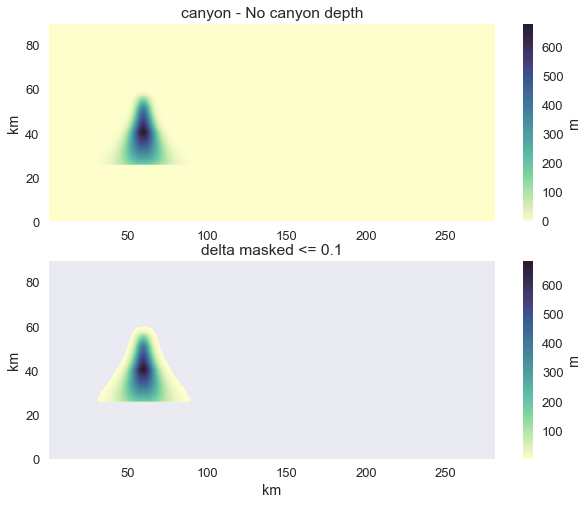

In [5]:
sns.set_context('talk')
fig, (ax1, ax2) = plt.subplots(2,1, figsize=(10,8))
mesh = ax1.pcolor(X[:]/1000,Y[:]/1000, delta, cmap = cmo.cm.deep)
cb = plt.colorbar(mesh, ax=ax1)
cb.set_label('m')
ax1.set_title('canyon - No canyon depth')
ax1.set_ylabel('km')

mesh = ax2.pcolor(X[:]/1000,Y[:]/1000, delta_masked, cmap = cmo.cm.deep)
cb = plt.colorbar(mesh, ax=ax2)
cb.set_label('m')
ax2.set_title('delta masked <= 5')
ax2.set_xlabel('km')
ax2.set_ylabel('km')

In [6]:
# Read in kp profiles from Monterey and Eel canyons

file_mty = '/ocean/kramosmu/Data/mean_kp_Monterey.csv'
file_eel = '/ocean/kramosmu/Data/mean_kp_Eel.csv'

data_mty = pd.read_csv(file_mty)
data_eel = pd.read_csv(file_eel)
   
kv_mty = data_mty['kp']
dep_mty = data_mty['depth']

kv_eel = data_eel['kp']
dep_eel = data_eel['depth']

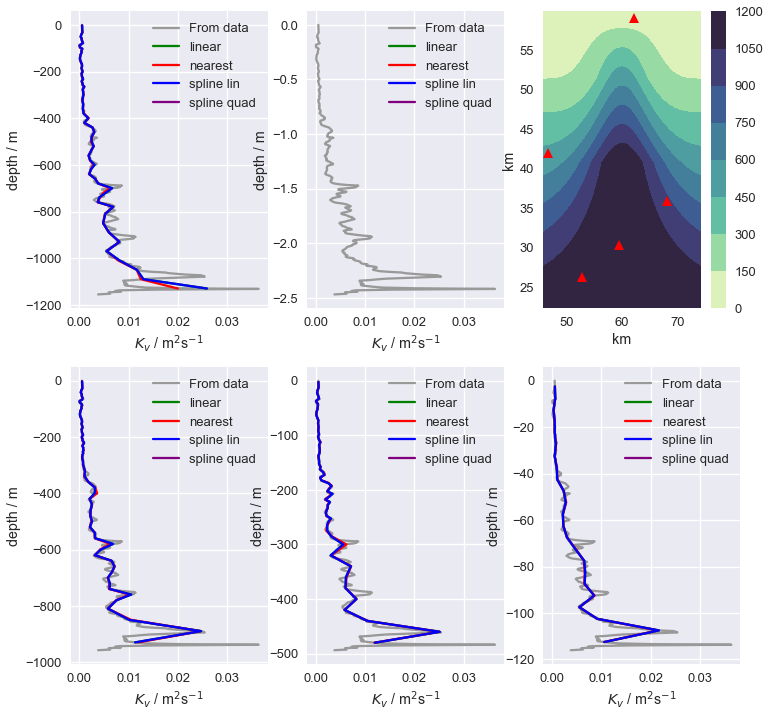

In [7]:
# Which interpolation to use? 
fig,((ax0,ax1, ax4),(ax2,ax3,ax5)) = plt.subplots(2,3, figsize=(12,12))

mesh = ax4.contourf(X[100:260]/1000,Y[60:270]/1000, depth_Can[60:270,100:260], cmap = cmo.cm.deep)
cb = plt.colorbar(mesh, ax=ax4)
ax4.set_ylabel('km')
ax4.set_xlabel('km')


ind_canyon = np.argwhere(delta > 0.1) # horizontal indices of canyon, (y,x)
ind_list = [100, 5000, 12000, 20000, 38000] # Choose 5 profiles within the canyon to check

for ind, ax in zip(ind_canyon[ind_list], [ax0,ax1,ax2,ax3,ax5]):
    
    bot_ind = np.argmin(hFacCcan[:,ind[0],ind[1]]) # find bottom z-index (first zero in hFacC)
    interp_z = RC[:bot_ind+1] # interp to water column above bottom
    
    F1 = interp.interp1d(dep_mty*RC[bot_ind], kv_mty,kind='linear', fill_value='extrapolate')
    F2 = interp.interp1d(dep_mty*RC[bot_ind], kv_mty,kind='nearest', fill_value='extrapolate')
    F3 = interp.interp1d(dep_mty*RC[bot_ind], kv_mty,kind='slinear')
    F4 = interp.interp1d(dep_mty*RC[bot_ind], kv_mty,kind='quadratic')
    
    kv_interp1 = F1(interp_z)
    kv_interp2 = F2(interp_z)
    kv_interp3 = F3(interp_z)
    kv_interp4 = F4(interp_z)
    
    ax.plot(kv_mty, dep_mty*RC[bot_ind],  '-', color='0.6', label = 'From data')
    ax.plot(kv_interp1, interp_z,  '-', color='g', label='linear')
    ax.plot(kv_interp2, interp_z,  '-', color='r', label='nearest')
    ax.plot(kv_interp3, interp_z,  '-', color='b', label='spline lin')
    ax.plot(kv_interp4, interp_z,  '-', color='purple', label='spline quad')
    ax.set_ylabel('depth / m')
    ax.set_xlabel('$K_v$ / m$^2$s$^{-1}$')
    ax.legend(loc=0)

    ax4.plot(X[ind[1]]/1000, Y[ind[0]]/1000, '^r')

In [13]:
# Build 3D array of diffusivities

kv_array = np.ones(np.shape(hFacCcan))*kv_bg # Initial kv array
ind_canyon = np.argwhere(delta > thresh) # horizontal indices of canyon, (y,x)

ii = 0

for ind in ind_canyon:
    
    bot_ind = np.argmin(hFacCcan[:,ind[0],ind[1]]) # find bottom z-index (first zero in hFacC)
    
    if bot_ind == 0: # this means hfac=1 through the whole water col
        bot_ind = 89
    
    interp_z = RC[:bot_ind] # interp to water column above bottom
    
    F = interp.interp1d(dep_mty*RC[bot_ind], kv_mty, kind='linear', fill_value='extrapolate')
    kv_interp = F(interp_z)
    
    kv_array[:bot_ind, ind[0], ind[1]] = kv_interp
    ii = ii+1
    
    if (ii % 1000) == 0:
        print('%d out of %d' %(ii,np.shape(ind_canyon)[0]))
   

1000 out of 31036
2000 out of 31036
3000 out of 31036
4000 out of 31036
5000 out of 31036
6000 out of 31036
7000 out of 31036
8000 out of 31036
9000 out of 31036
10000 out of 31036
11000 out of 31036
12000 out of 31036
13000 out of 31036
14000 out of 31036
15000 out of 31036
16000 out of 31036
17000 out of 31036
18000 out of 31036
19000 out of 31036
20000 out of 31036
21000 out of 31036
22000 out of 31036
23000 out of 31036
24000 out of 31036
25000 out of 31036
26000 out of 31036
27000 out of 31036
28000 out of 31036
29000 out of 31036
30000 out of 31036
31000 out of 31036


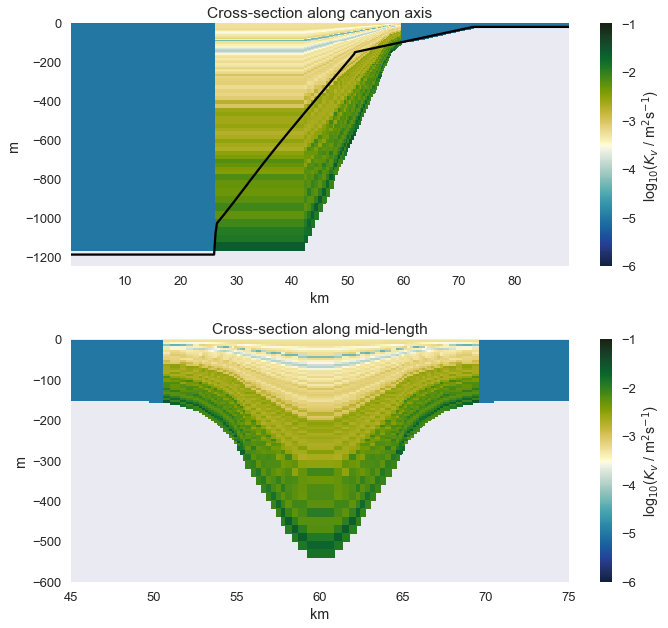

In [15]:
# Check cross-section

masked_logkv = np.ma.masked_array(np.log10(kv_array), mask = land_mask)

fig, (ax1, ax2) = plt.subplots(2,1, figsize=(10,9))

mesh = ax1.pcolor(Y[:]/1000,RC[:], masked_logkv[:,:,180] , vmax=-1, vmin=-6, cmap = cmo.cm.delta)
cb = plt.colorbar(mesh, ax=ax1)
cb.set_label(r'log$_{10}$($K_v$ / m$^2$s$^{-1}$)')
ax1.set_title('Cross-section along canyon axis')
ax1.set_ylabel('m')
ax1.set_xlabel('km')
ax1.plot(Y[:]/1000, -depth_Can[:,280], 'k-')

mesh = ax2.pcolor(X[:]/1000,RC[:], masked_logkv[:,227,:], vmax=-1, vmin=-6, cmap = cmo.cm.delta)
cb = plt.colorbar(mesh, ax=ax2)
cb.set_label(r'log$_{10}$($K_v$ / m$^2$s$^{-1}$)')
ax2.set_title('Cross-section along mid-length')
ax2.set_ylabel('m')
ax2.set_xlabel('km')
ax2.set_ylim(-600,0)
ax2.set_xlim(45,75)

plt.tight_layout()

In [10]:
# saving binary files



In [11]:
# Check that the values of the file are in the right order 

